In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

138.430997671 60.8595704834 (112, 92)


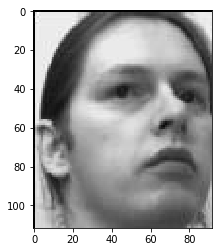

In [2]:
im = Image.open("image/umist_cropped.jpg")
data_orig = np.array(im)

ws = (112,92)
data = data_orig[ws[0]:2*ws[0],ws[1]:ws[1]*2]
print(np.mean(data), np.std(data), data.shape)
plt.imshow(data, cmap='gray')
plt.show()

In [3]:
def gibbs(X, gamma_shape, gamma_scale, max_iter):
    W = X.shape[0]
    K = X.shape[1]
    I = 20
    A_t = np.ones((W,I))*gamma_shape
    B_t = np.ones((W,I))*gamma_scale
    A_v = np.ones((I,K))*gamma_shape
    B_v = np.ones((I,K))*gamma_scale
    
    T = np.random.gamma(A_t,B_t)
    V = np.random.gamma(A_v,B_v)

    for n in range(max_iter):

        p = np.zeros((W, I ,K))
        S = np.zeros((W, I ,K))

        p = np.einsum("ik,kj->ikj", T, V)
        p = p/np.sum(p, axis = 1, keepdims = True)

        for v in range(W):
            for t in range(K):
                S[v, :, t] = np.random.binomial(X[v,t], p[v, :, t].squeeze())


        alpha_t = A_t + np.sum(S, axis=2)
        beta_t = 1./(B_t + np.einsum("i,kj,j->ik",np.ones(W),V,np.ones(K)))
        T = np.random.gamma(alpha_t, beta_t)
        
        alpha_v = A_v + np.sum(S, axis=0)
        beta_v = 1./(B_v + np.einsum("i,ik,j->kj", np.ones(W), T, np.ones(K)))
        V = np.random.gamma(alpha_v, beta_v)

        if n % 50 == 0:
            mean_diff = np.mean(np.abs(X - np.dot(T,V)))
            print("epoch %d: loss: "%n, mean_diff)
    return T, V

In [4]:
#Initialization
X = data
W = X.shape[0]
K = X.shape[1]
I = 20

data_variance = (np.std(X)/I)**2
data_mean = np.mean(X)/I/2.5

gamma_scale = data_variance/data_mean
gamma_shape = data_mean/gamma_scale

T, V = gibbs(X, gamma_shape, gamma_scale, 400)

epoch 0: loss:  42.7776244395
epoch 50: loss:  11.8732900839
epoch 100: loss:  8.91921959715
epoch 150: loss:  8.0423110819
epoch 200: loss:  7.68958826518
epoch 250: loss:  7.45411111136
epoch 300: loss:  7.36730778171
epoch 350: loss:  7.41227787458


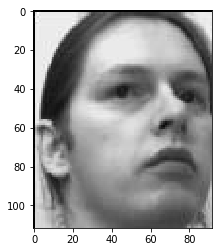

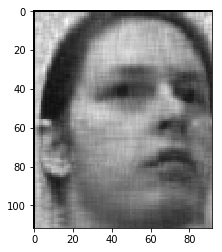

138.430997671 60.8595704834
137.197320319 59.6955124392


In [5]:
plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(np.dot(T,V), cmap='gray')
plt.show()
print(np.mean(X), np.std(X))
print(np.mean(np.dot(T,V)), np.std(np.dot(T,V)))

In [6]:
def gibbs_mask(X, mask, gamma_shape, gamma_scale, max_iter):
    
    X = X*mask
    
    W = X.shape[0]
    K = X.shape[1]
    I = 20
    A_t = np.ones((W,I))*gamma_shape
    B_t = np.ones((W,I))*gamma_scale
    A_v = np.ones((I,K))*gamma_shape
    B_v = np.ones((I,K))*gamma_scale
    
    T = np.random.gamma(A_t,B_t)
    V = np.random.gamma(A_v,B_v)

    for n in range(max_iter):

        p = np.zeros((W, I ,K))
        S = np.zeros((W, I ,K))

        p = np.einsum("ik,kj->ikj", T, V)
        
        #p = np.einsum("ikj,ij->ikj",p,mask)
        
        p = p/np.sum(p, axis = 1, keepdims = True)

        for v in range(W):
            for t in range(K):
                S[v, :, t] = np.random.binomial(X[v,t], p[v, :, t].squeeze())


        alpha_t = A_t + np.sum(S, axis=2)
        beta_t = 1./(B_t + np.einsum("ij, kj->ik",mask,V))
        T = np.random.gamma(alpha_t, beta_t)
        
        alpha_v = A_v + np.sum(S, axis=0)
        beta_v = 1./(B_v + np.einsum("ij, ik->kj",mask,T))
        V = np.random.gamma(alpha_v, beta_v)

        if n % 50 == 0:
            mean_diff = np.mean(np.abs(X - np.dot(T,V)))
            print("epoch %d: loss: "%n, mean_diff)
    return T, V

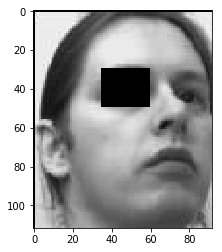

In [7]:
mask = np.ones((W,K)).astype(np.uint8)
mask[30:50,35:60] = 0
plt.imshow(X*mask, cmap='gray')
plt.show()

In [8]:
#Initialization
X = data
W = X.shape[0]
K = X.shape[1]
I = 20

data_variance = (np.std(X)/I)**2
data_mean = np.mean(X)/I/2.5

gamma_scale = data_variance/data_mean
gamma_shape = data_mean/gamma_scale

T_, V_ = gibbs_mask(X, mask, gamma_shape, gamma_scale, 400)

epoch 0: loss:  47.2887139318
epoch 50: loss:  18.5229244268
epoch 100: loss:  14.8784228316
epoch 150: loss:  13.3423734906
epoch 200: loss:  12.6023482222
epoch 250: loss:  12.3049826911
epoch 300: loss:  11.8152148935
epoch 350: loss:  11.4584880017


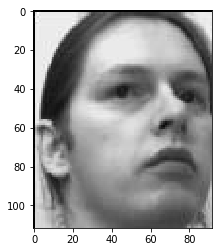

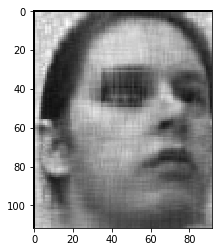

138.430997671 60.8595704834
135.695248386 60.3018008663


In [9]:
plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(np.dot(T_,V_), cmap='gray')
plt.show()
print(np.mean(X), np.std(X))
print(np.mean(np.dot(T_,V_)), np.std(np.dot(T_,V_)))